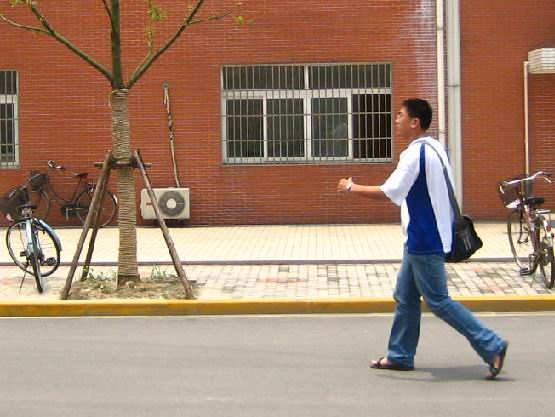

In [2]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00020.png')

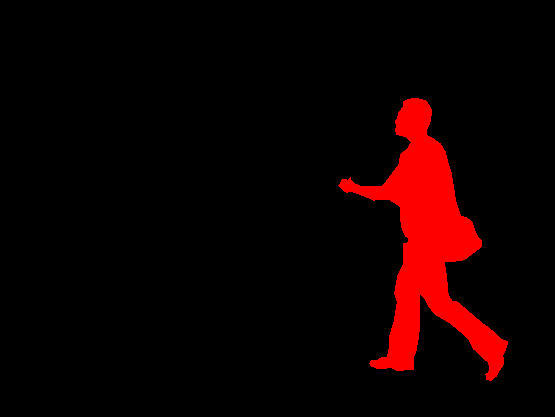

In [6]:
mask = Image.open('PennFudanPed/PedMasks/FudanPed00020_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.

mask = mask.convert('P')

mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
    200,200,200, # index 4
])
mask